In [1]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv",
                             usecols=['date', 'キロ程', '高低左'],
                             parse_dates=["date"])

In [2]:
%matplotlib inline

In [3]:
import datetime
from tqdm import tqdm
import random
import sys

In [4]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return np.array(day)

In [5]:
def feature_engineering(df, dmm, mv, admm):
    if dmm:
         df['diff_moving_mean'] = df['高低左'] - df['高低左'].rolling(window=7, min_periods=1, center=True).median()
    if mv:
        df['moving_variance'] = df['高低左'].rolling(window=7, min_periods=1, center=True).kurt()
    if admm:
        df['accumulation_diff_moving_mean'] = np.cumsum(
            abs(df['高低左'].rolling(window=3, min_periods=1, center=True).median() -
                df['高低左'].rolling(window=15, min_periods=1, center=False).median()))
    return df

In [6]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [7]:
def scaling(df, w1, w2, w3, w4):
    df['day'] = ss.fit_transform(df['day'].astype(float).values.reshape(len(df), 1))
    if w1 != 0:
        df['高低左'] = ss.fit_transform(df['高低左'].values.reshape(len(df), 1))*w1
    if w2 != 0:
        df['diff_moving_mean'] = ss.fit_transform(df['diff_moving_mean'].values.reshape(len(df), 1))*w2
    if w3 != 0:
        df['moving_variance'] = df['moving_variance'].fillna(0) #rollingした高低左が全部同じ値のときはNANになる
        df['moving_variance'] = ss.fit_transform(df['moving_variance'].values.reshape(len(df), 1))*w3
    if w4 != 0:
        df['accumulation_diff_moving_mean'] = \
        ss.fit_transform(df['accumulation_diff_moving_mean'].values.reshape(len(df), 1))*w4
    return df

In [8]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [9]:
def kd_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99999, False, True)].index.values
    return normal_id

In [10]:
def kd_outliers1(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.999, False, True)].index.values
    return normal_id

In [11]:
def kd_outliers2(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99998, False, True)].index.values
    return normal_id

In [12]:
from scipy.cluster.hierarchy import linkage, fcluster

In [13]:
def dendrogram_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, False, True)
    df = scaling(df, 10, 50, 0, 100)

    linkage_result = linkage(df, method='ward', metric='euclidean')
    threshold = 0.95 * np.max(linkage_result[:, 2])
    clustered = fcluster(linkage_result, threshold, criterion='distance')

    df['label'] = clustered
    normal_label = df['label'].mode()[0]
    normal_id = df[df['label'] == normal_label].index.values
    return normal_id

In [14]:
def remove_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])
    return local_global[3][1]

def flag_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])

    out1 = set(local_global[0][1]) - set(local_global[1][1])
    out2 = set(local_global[1][1]) - set(local_global[2][1])
    out3 = set(local_global[2][1]) - set(local_global[3][1])
    normal = local_global[3][1]
    return out1, out2, out3, normal

fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['C']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [16]:
def get_slope_variance(X, y):
    if len(X) < 10:
        slope = 100
        variance = 100
    else:
        data = np.array([X, y]).T
        pca.fit(data)
        cmp = pca.components_
        cov = pca.get_covariance()

        slope = cmp[0, 1] / cmp[0, 0]
        variance = cov[1, 1] / cov[0, 0]

    return slope, variance

In [17]:
def get_intercept(raw):
    data = raw.copy()
    if sum(data['date'] >= "2018-03-01") == 0:
        print('sum(data["date"] >= "2018-03-01") == 0')
        intercept = np.median(data['高低左'].values[-10:])

    else:
        data = data.loc[data['date'] >= "2018-03-01"]
        data = data.reset_index(drop=True)
        data = data.drop('date', axis=1)
        if len(data) < 4:
            print('sum(data["date"] >= "2018-03-01") < 4')
            intercept = np.median(data['高低左'].values)

        else:
            normal_id = kd_outliers1(data)
            data = data.loc[normal_id]
            intercept = np.median(data['高低左'].values)

    return intercept

In [47]:
summarys_left = {}
for no in ['A', 'B', 'C', 'D']:
    summarys_left[no] = pd.read_csv(f'summary12_refine_{no}.csv', index_col=0)

In [48]:
summarys_right = {}
for no in ['A', 'B', 'C', 'D']:
    summarys_right[no] = pd.read_csv(f'summary12_right_{no}.csv', index_col=0)

In [49]:
for no in ['A', 'B', 'C', 'D']:
    summarys_left[no].loc[summarys_left[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys_left[no].loc[summarys_left[no]['傾き'].notnull(), '傾き'])
    summarys_left[no].loc[summarys_left[no]['分散比'] == 100, '分散比'] = \
    np.median(summarys_left[no].loc[summarys_left[no]['分散比'].notnull(), '分散比'])
    summarys_left[no].loc[summarys_left[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys_left[no].loc[summarys_left[no]['傾き'].notnull(), '傾き'])
    summarys_left[no].loc[summarys_left[no]['切片'].isnull(), '切片'] = \
    np.median(summarys_left[no].loc[summarys_left[no]['切片'].notnull(), '切片'])

In [50]:
for no in ['A', 'B', 'C', 'D']:
    summarys_right[no].loc[summarys_right[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys_right[no].loc[summarys_right[no]['傾き'].notnull(), '傾き'])
    summarys_right[no].loc[summarys_right[no]['分散比'] == 100, '分散比'] = \
    np.median(summarys_right[no].loc[summarys_right[no]['分散比'].notnull(), '分散比'])
    summarys_right[no].loc[summarys_right[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys_right[no].loc[summarys_right[no]['傾き'].notnull(), '傾き'])
    summarys_right[no].loc[summarys_right[no]['切片'].isnull(), '切片'] = \
    np.median(summarys_right[no].loc[summarys_right[no]['切片'].notnull(), '切片'])

In [51]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

In [52]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys_left[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys_left[no]['傾き'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [53]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys_right[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys_right[no]['傾き'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [54]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = summarys_left[no]
    summarys[no]['傾き'] = (summarys_left[no]['傾き'] + summarys_right[no]['傾き'])*0.5

In [55]:
p = []
intercept_day = 15
for no in ['A', 'B', 'C', 'D']:
    summary = summarys[no]
    for i in range(91):
        day = summary['切片'].values + summary['傾き'].values*(i+intercept_day)
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし

0


In [56]:
submision.max()

0    18.27
dtype: float64

In [57]:
submision.min()

0   -17.83
dtype: float64

submision.loc[submision[0] > 16, 0] = 16
submision.loc[submision[0] < -16, 0] = -16

In [58]:
len(submision[submision[0] >= 16])
len(submision[submision[0] <= -16])

396

606

In [59]:
submision

,0
0,0.36
1,2.67
2,4.99
3,5.96
4,5.03
5,1.68
6,-3.14
7,-7.09
8,-8.82
9,-7.43


Text(0.5, 1.0, 'kilo: 28723,  kilo_id: 18723')

Text(0.5, 1.0, 'kilo: 11067,  kilo_id: 1067')

Text(0.5, 1.0, 'kilo: 24053,  kilo_id: 14053')

Text(0.5, 1.0, 'kilo: 25812,  kilo_id: 15812')

Text(0.5, 1.0, 'kilo: 28942,  kilo_id: 18942')

Text(0.5, 1.0, 'kilo: 10486,  kilo_id: 486')

Text(0.5, 1.0, 'kilo: 16753,  kilo_id: 6753')

Text(0.5, 1.0, 'kilo: 25157,  kilo_id: 15157')

Text(0.5, 1.0, 'kilo: 36650,  kilo_id: 26650')

Text(0.5, 1.0, 'kilo: 26098,  kilo_id: 16098')

Text(0.5, 1.0, 'kilo: 36987,  kilo_id: 26987')

Text(0.5, 1.0, 'kilo: 19093,  kilo_id: 9093')

Text(0.5, 1.0, 'kilo: 31412,  kilo_id: 21412')

Text(0.5, 1.0, 'kilo: 36562,  kilo_id: 26562')

Text(0.5, 1.0, 'kilo: 15250,  kilo_id: 5250')

Text(0.5, 1.0, 'kilo: 11127,  kilo_id: 1127')

Text(0.5, 1.0, 'kilo: 27061,  kilo_id: 17061')

Text(0.5, 1.0, 'kilo: 26059,  kilo_id: 16059')

Text(0.5, 1.0, 'kilo: 20740,  kilo_id: 10740')

Text(0.5, 1.0, 'kilo: 12493,  kilo_id: 2493')

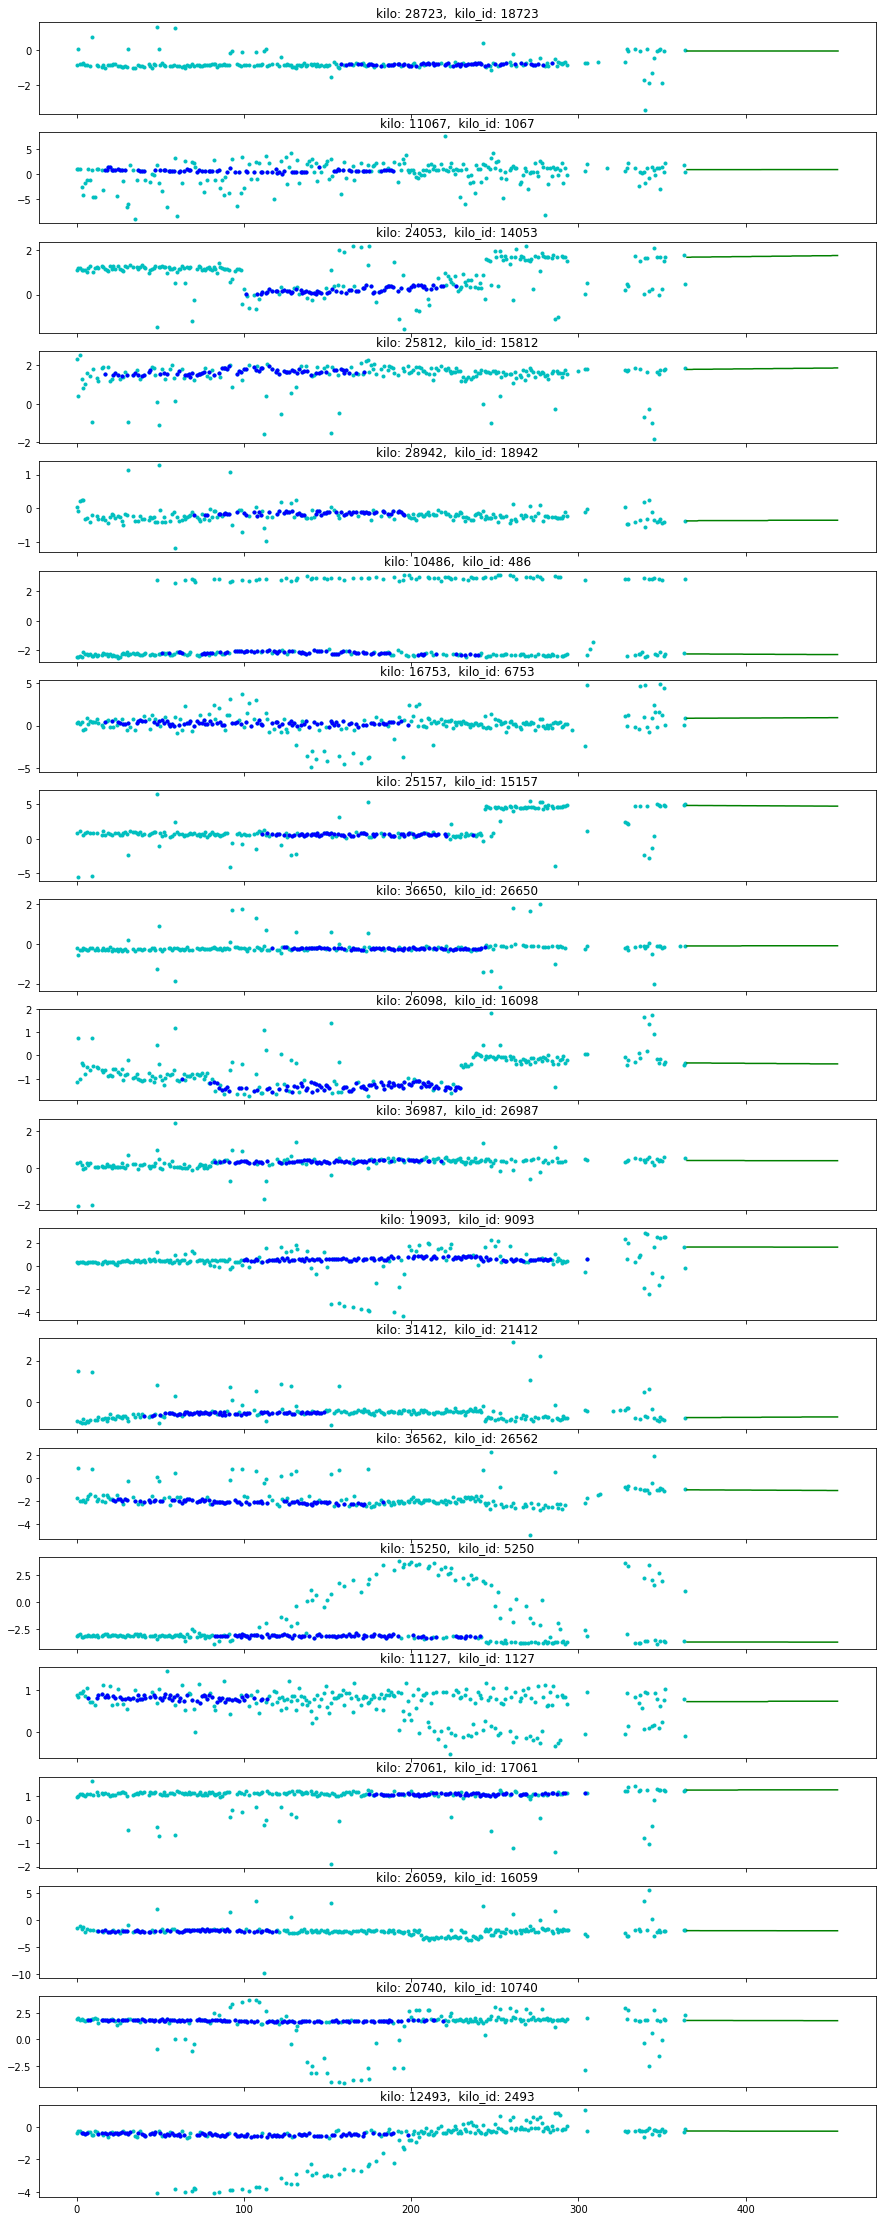

In [61]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 22623,  kilo_id: 12623')

Text(0.5, 1.0, 'kilo: 23781,  kilo_id: 13781')

Text(0.5, 1.0, 'kilo: 11326,  kilo_id: 1326')

Text(0.5, 1.0, 'kilo: 18484,  kilo_id: 8484')

Text(0.5, 1.0, 'kilo: 26753,  kilo_id: 16753')

Text(0.5, 1.0, 'kilo: 25922,  kilo_id: 15922')

Text(0.5, 1.0, 'kilo: 23268,  kilo_id: 13268')

Text(0.5, 1.0, 'kilo: 19938,  kilo_id: 9938')

Text(0.5, 1.0, 'kilo: 25617,  kilo_id: 15617')

Text(0.5, 1.0, 'kilo: 21732,  kilo_id: 11732')

Text(0.5, 1.0, 'kilo: 29116,  kilo_id: 19116')

Text(0.5, 1.0, 'kilo: 17157,  kilo_id: 7157')

Text(0.5, 1.0, 'kilo: 26537,  kilo_id: 16537')

Text(0.5, 1.0, 'kilo: 14563,  kilo_id: 4563')

Text(0.5, 1.0, 'kilo: 19235,  kilo_id: 9235')

Text(0.5, 1.0, 'kilo: 14579,  kilo_id: 4579')

Text(0.5, 1.0, 'kilo: 13107,  kilo_id: 3107')

Text(0.5, 1.0, 'kilo: 30262,  kilo_id: 20262')

Text(0.5, 1.0, 'kilo: 18208,  kilo_id: 8208')

Text(0.5, 1.0, 'kilo: 27451,  kilo_id: 17451')

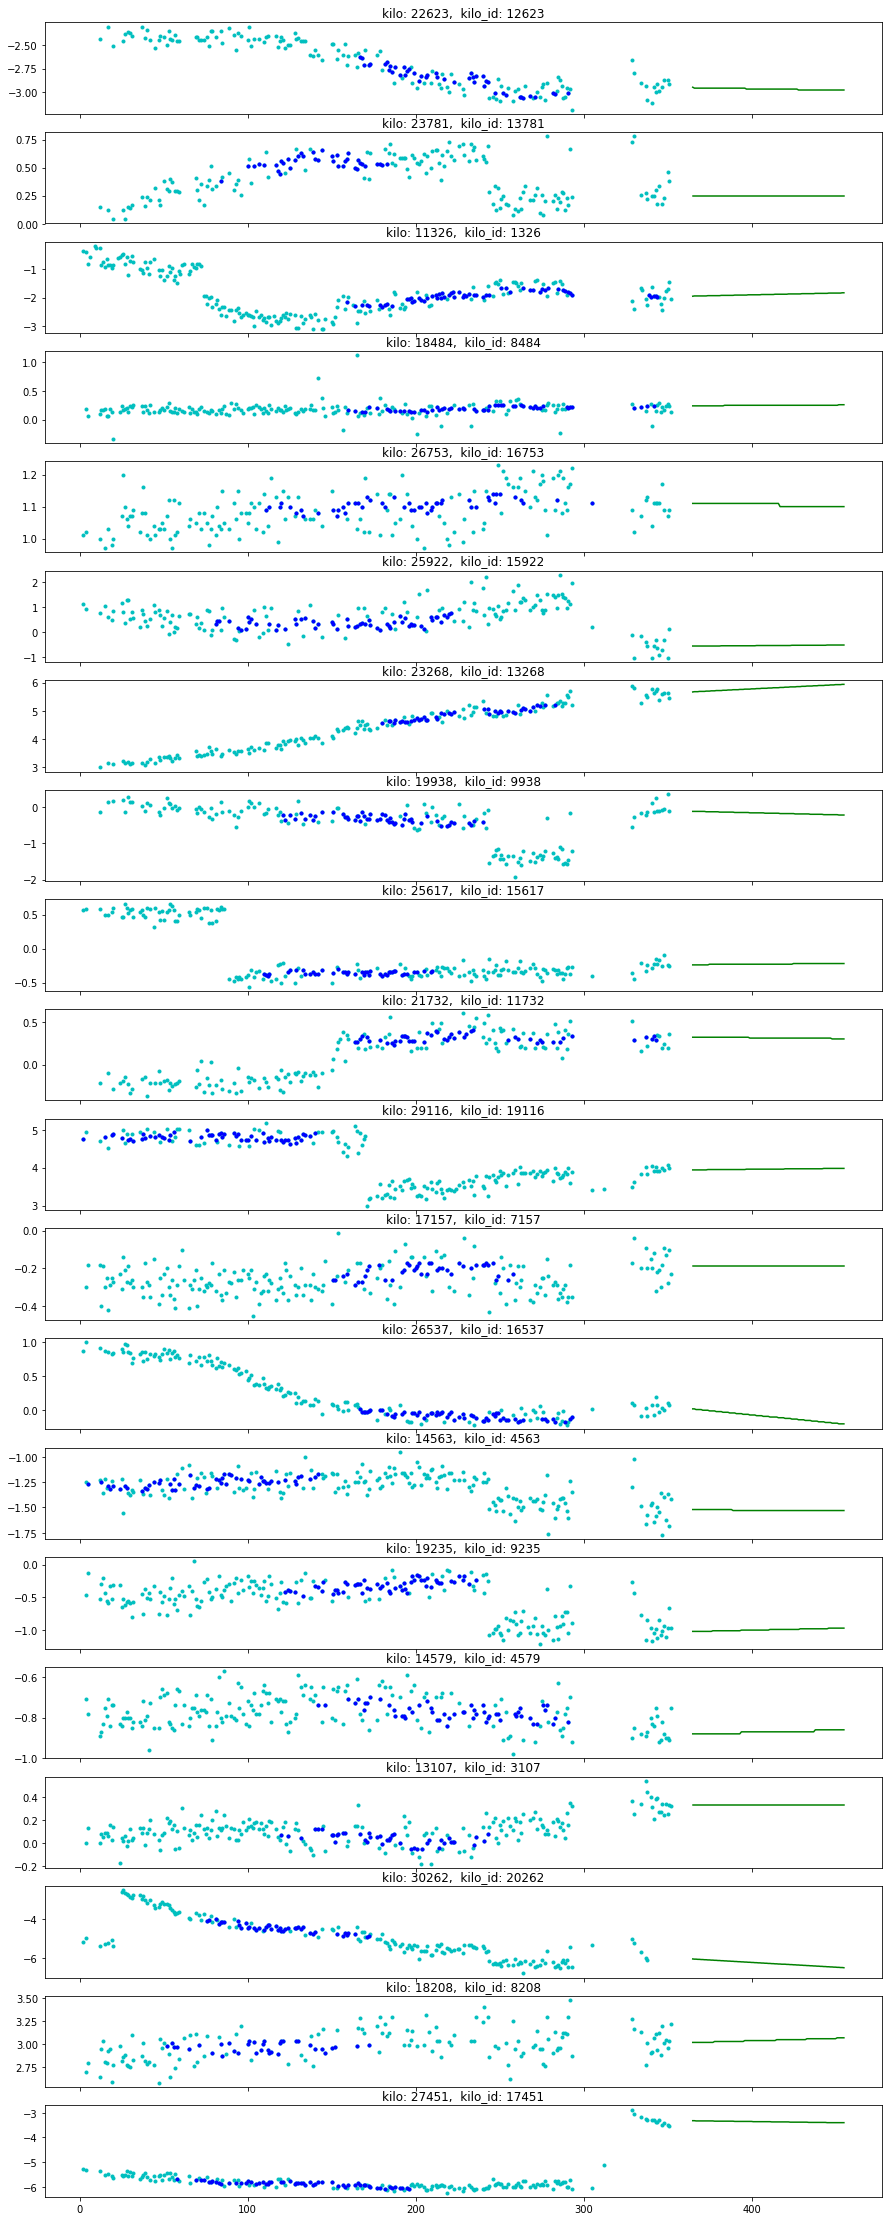

In [62]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['B']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 65340,  kilo_id: 55340')

Text(0.5, 1.0, 'kilo: 35247,  kilo_id: 25247')

Text(0.5, 1.0, 'kilo: 59673,  kilo_id: 49673')

Text(0.5, 1.0, 'kilo: 37562,  kilo_id: 27562')

Text(0.5, 1.0, 'kilo: 12653,  kilo_id: 2653')

Text(0.5, 1.0, 'kilo: 26968,  kilo_id: 16968')

Text(0.5, 1.0, 'kilo: 43506,  kilo_id: 33506')

Text(0.5, 1.0, 'kilo: 41845,  kilo_id: 31845')

Text(0.5, 1.0, 'kilo: 36537,  kilo_id: 26537')

Text(0.5, 1.0, 'kilo: 61367,  kilo_id: 51367')

Text(0.5, 1.0, 'kilo: 64385,  kilo_id: 54385')

Text(0.5, 1.0, 'kilo: 29877,  kilo_id: 19877')

Text(0.5, 1.0, 'kilo: 41234,  kilo_id: 31234')

Text(0.5, 1.0, 'kilo: 33465,  kilo_id: 23465')

Text(0.5, 1.0, 'kilo: 48232,  kilo_id: 38232')

Text(0.5, 1.0, 'kilo: 24315,  kilo_id: 14315')

Text(0.5, 1.0, 'kilo: 43075,  kilo_id: 33075')

Text(0.5, 1.0, 'kilo: 19127,  kilo_id: 9127')

Text(0.5, 1.0, 'kilo: 28470,  kilo_id: 18470')

Text(0.5, 1.0, 'kilo: 19158,  kilo_id: 9158')

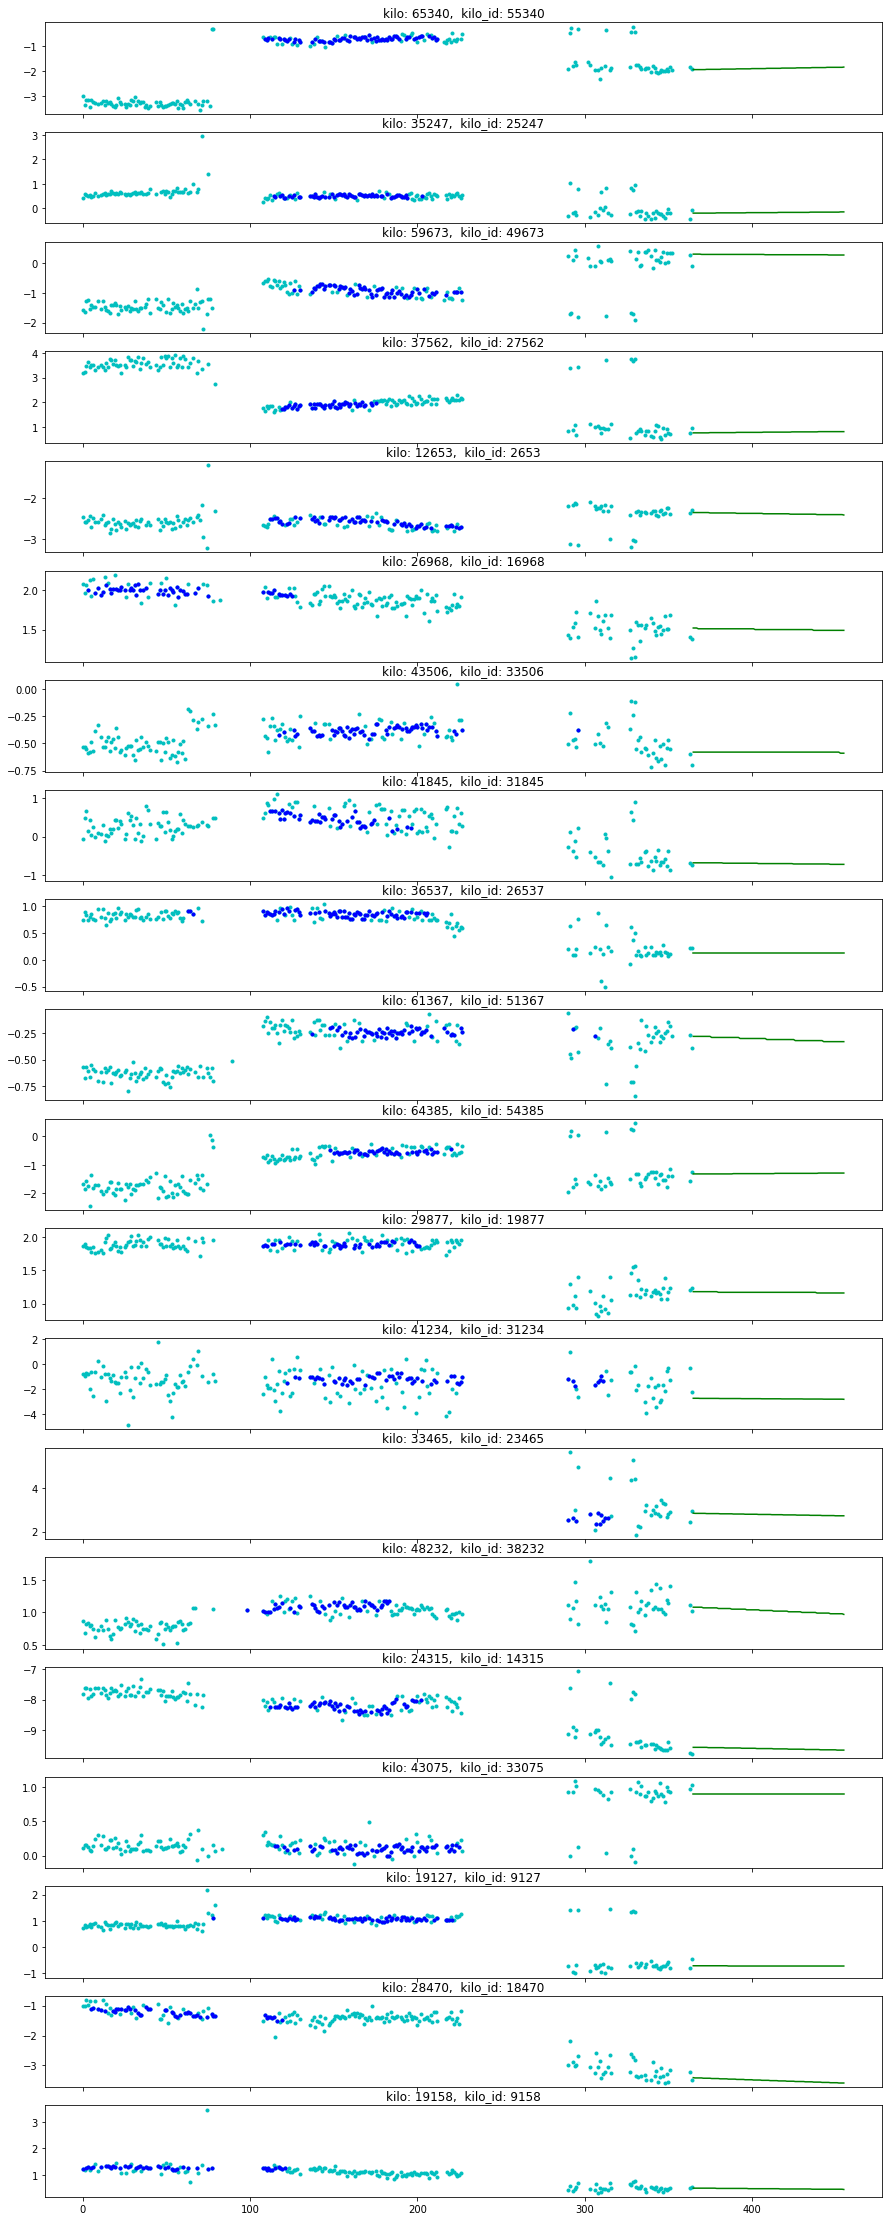

In [63]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['C']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 23835,  kilo_id: 13835')

Text(0.5, 1.0, 'kilo: 16311,  kilo_id: 6311')

Text(0.5, 1.0, 'kilo: 22418,  kilo_id: 12418')

Text(0.5, 1.0, 'kilo: 24585,  kilo_id: 14585')

Text(0.5, 1.0, 'kilo: 16890,  kilo_id: 6890')

Text(0.5, 1.0, 'kilo: 10663,  kilo_id: 663')

Text(0.5, 1.0, 'kilo: 14242,  kilo_id: 4242')

Text(0.5, 1.0, 'kilo: 18376,  kilo_id: 8376')

Text(0.5, 1.0, 'kilo: 17961,  kilo_id: 7961')

Text(0.5, 1.0, 'kilo: 16634,  kilo_id: 6634')

Text(0.5, 1.0, 'kilo: 25044,  kilo_id: 15044')

Text(0.5, 1.0, 'kilo: 22841,  kilo_id: 12841')

Text(0.5, 1.0, 'kilo: 23596,  kilo_id: 13596')

Text(0.5, 1.0, 'kilo: 14969,  kilo_id: 4969')

Text(0.5, 1.0, 'kilo: 17808,  kilo_id: 7808')

Text(0.5, 1.0, 'kilo: 15866,  kilo_id: 5866')

Text(0.5, 1.0, 'kilo: 19558,  kilo_id: 9558')

Text(0.5, 1.0, 'kilo: 24608,  kilo_id: 14608')

Text(0.5, 1.0, 'kilo: 24878,  kilo_id: 14878')

Text(0.5, 1.0, 'kilo: 13578,  kilo_id: 3578')

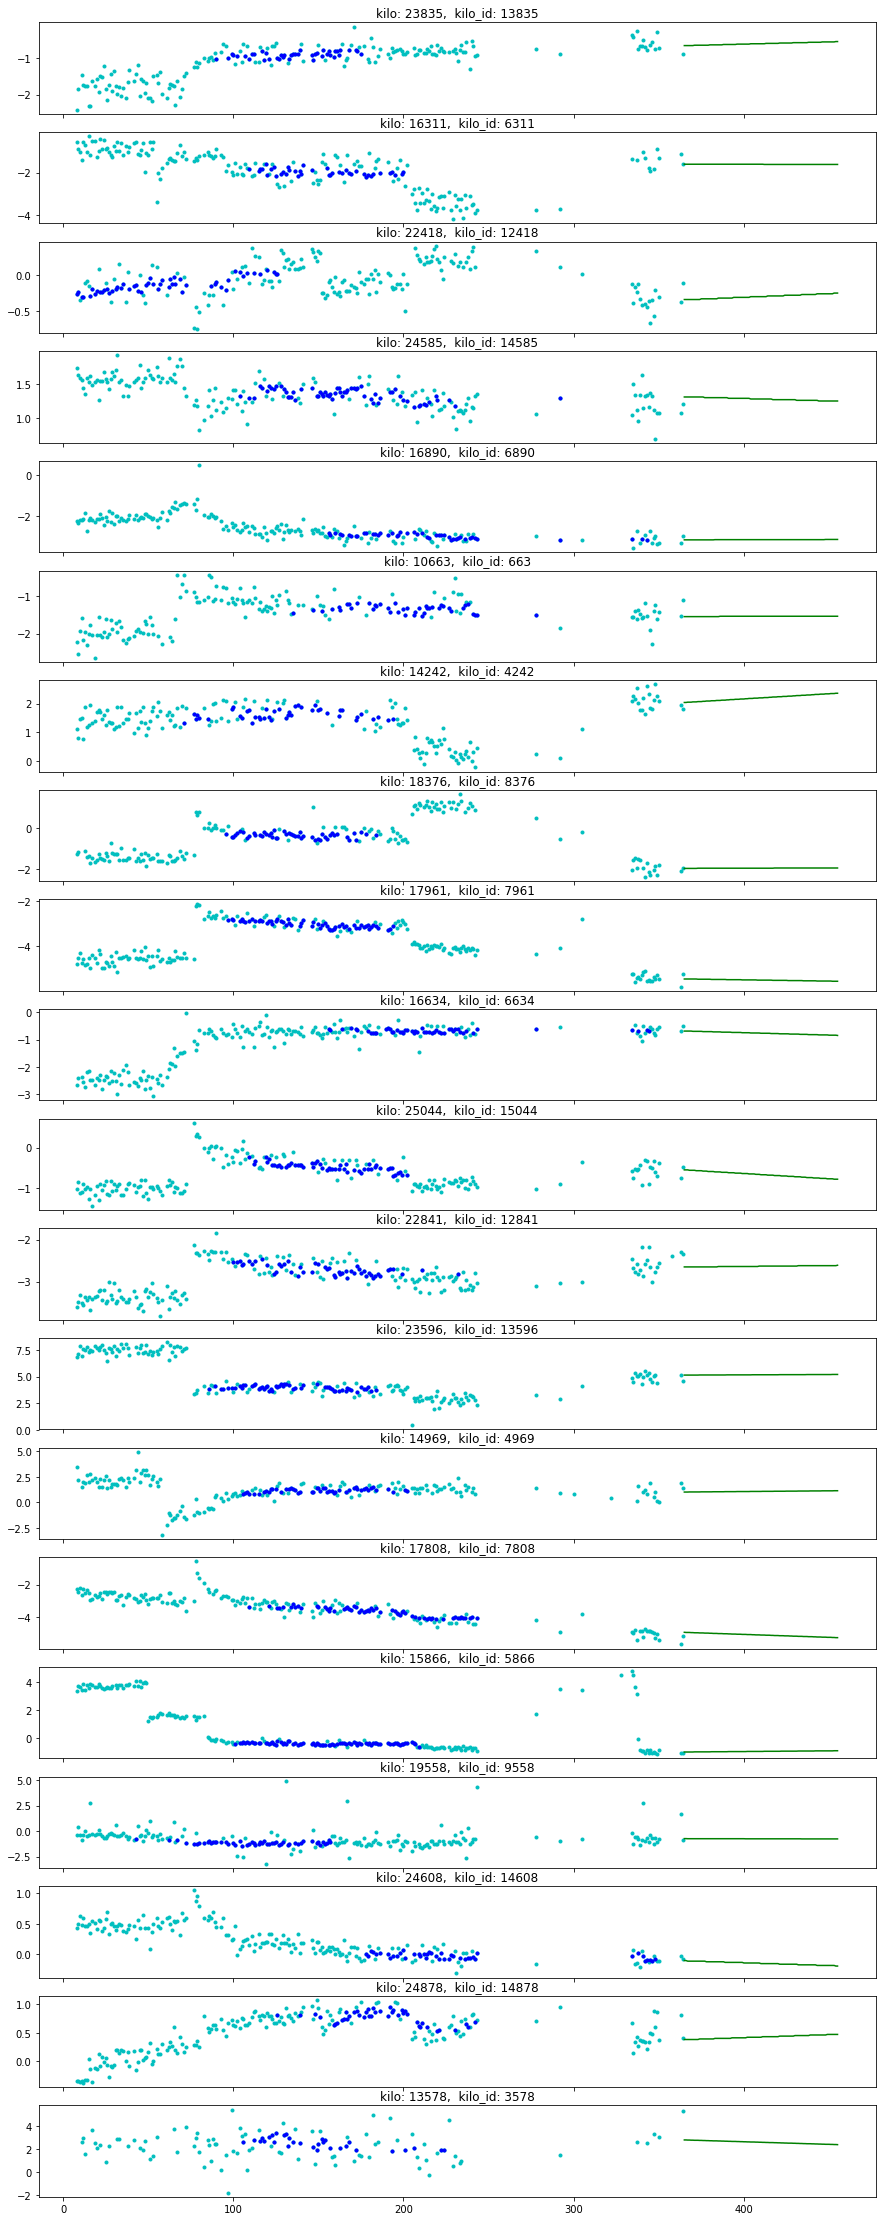

In [64]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['D']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91 + len(tracks['C']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [60]:
submision.to_csv("submit17.csv", header=None)